# Popularity based movie recommender
> A simple popular movie recommender and eda on movielens-100k dataset with the help of cornac library

- toc: true
- badges: true
- comments: true
- categories: [Movie, Cornac]
- author: "<a href='https://nbviewer.jupyter.org/github/PreferredAI/tutorials/tree/master/recommender-systems/'>Cornac</a>"
- image:

## Setup

In [1]:
!pip install -q cornac==1.4.1

     |████████████████████████████████| 8.0MB 8.8MB/s 


In [2]:
import os
import sys

import cornac
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, sparse

%matplotlib inline

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")

System version: 3.7.10 (default, May  3 2021, 02:48:31) 
[GCC 7.5.0]
Cornac version: 1.4.1


## Movielens Data

In [3]:
data = cornac.datasets.movielens.load_feedback(variant="100K")
df = pd.DataFrame(data, columns=["user_id", "item_id", "rating"])
df.head()

0.00B [00:00, ?B/s]

Data from http://files.grouplens.org/datasets/movielens/ml-100k/u.data
will be cached into /root/.cornac/ml-100k/u.data


1.99MB [00:00, 2.61MB/s]                           


File cached!


,user_id,item_id,rating
0,196,242,3.0
1,186,302,3.0
2,22,377,1.0
3,244,51,2.0
4,166,346,1.0


## EDA

In [7]:
n_users = df.user_id.nunique()
n_items = df.item_id.nunique()
n_ratings = len(df)
rating_matrix_size = n_users * n_items
sparsity = 1 - n_ratings / rating_matrix_size

print(f"Number of users: {n_users}")
print(f"Number of items: {n_items}")
print(f"Number of available ratings: {n_ratings}")
print(f"Number of all possible ratings: {rating_matrix_size}")
print("-" * 40)
print(f"SPARSITY: {sparsity * 100.0:.2f}%")

Number of users: 943
Number of items: 1682
Number of available ratings: 100000
Number of all possible ratings: 1586126
----------------------------------------
SPARSITY: 93.70%


> Note: For this MovieLens dataset, the data has been prepared in such a way that each user has at least 20 ratings. As a result, it's relatively dense as compared to many other recommendation datasets that are usually much sparser (often 99% or more).

In [5]:
df.rating.describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

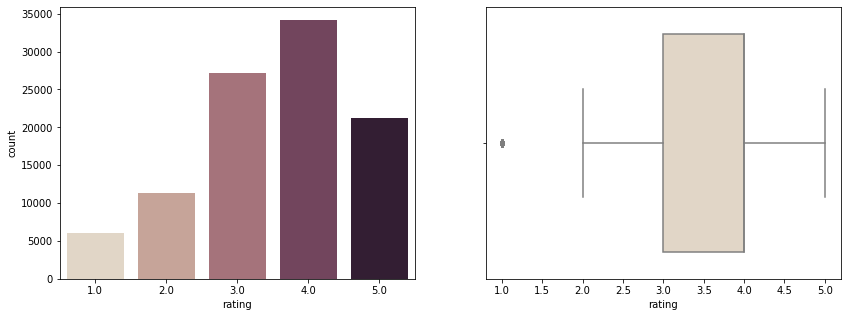

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
sns.countplot(x="rating", data=df, palette="ch:.25", ax=axes[0])
sns.boxplot(x="rating", data=df, palette="ch:.25", ax=axes[1])

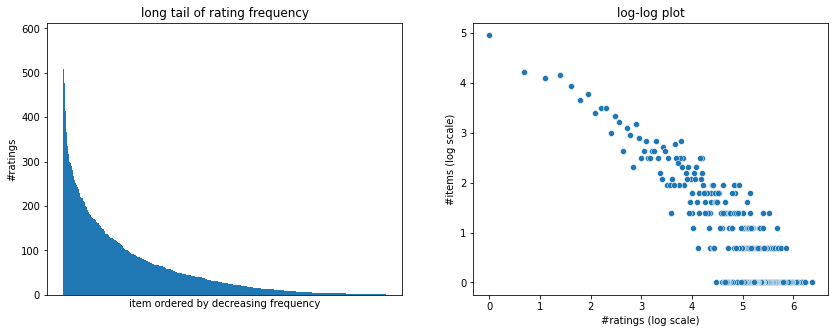

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

item_rate_count = df.groupby("item_id")["user_id"].nunique().sort_values(ascending=False)

axes[0].bar(x=item_rate_count.index, height=item_rate_count.values, width=1.0, align="edge")
axes[0].set_xticks([])
axes[0].set(title="long tail of rating frequency", 
            xlabel="item ordered by decreasing frequency", 
            ylabel="#ratings")

count = item_rate_count.value_counts()
sns.scatterplot(x=np.log(count.index), y=np.log(count.values), ax=axes[1])
axes[1].set(title="log-log plot", xlabel="#ratings (log scale)", ylabel="#items (log scale)");

## Recommendation Based on Item Popularity

In [10]:
# 5-fold cross validation
eval_method = cornac.eval_methods.CrossValidation(data, n_folds=5, seed=42)

# recommender system based on item popularity
most_pop = cornac.models.MostPop()

# recall@20 metric
rec_20 = cornac.metrics.Recall(k=20)

# put everything together into an experiment
cornac.Experiment(eval_method=eval_method, models=[most_pop], metrics=[rec_20]).run()


TEST:
...
[MostPop]
       | Recall@20 | Train (s) | Test (s)
------ + --------- + --------- + --------
Fold 0 |    0.1263 |    0.0107 |   0.4143
Fold 1 |    0.1304 |    0.0052 |   0.4032
Fold 2 |    0.1337 |    0.0053 |   0.4024
Fold 3 |    0.1252 |    0.0137 |   0.4291
Fold 4 |    0.1187 |    0.0053 |   0.3992
------ + --------- + --------- + --------
Mean   |    0.1269 |    0.0080 |   0.4096
Std    |    0.0051 |    0.0035 |   0.0110

